# 'Adventure' Playlist - Music Recommendations For Variety And The Long Tail

# Notebook 04 - Clustering

&nbsp;

**By: [Jonathan Yeung](https://github.com/jonathan-yeung)**

In this notebook, I intend to find clusters of the music in the database using clustering techniques. I will use K-Means Clustering, Agglomerative Hierarchical Clustering, Gaussian Mixture Models and DBSCAN, compare their results and find the most suitable model for grouping and labelling. The clusters found will later be used as an evaluation of how well the recommender system helps users find new tracks different from the users' listening history.

---

# Table of Contents

1. [**Data Dictionary for the 7 Audio Features**](#DataDictAF)<br>

2. [**Imports**](#Imports)<br>

3. [**Data**](#Data)<br>

4. [**Scaling**](#Scaling)<br>

5. [**Clustering Models**](#Clustering)<br>
  5.1 [K-Means Clustering](#kmeans)<br>
  5.2 [Agglomerative Hierarchical Clustering](#agg)<br>
  5.3 [Gaussian Mixture Models](#gmm)<br>
  5.4 [DBSCAN](#dbscan)<br>

6. [**K-Means Clustering with k=7**](#kmeans7)<br>
  6.1 [Pairplots](#Pairplots)<br>
  6.2 [df_track_label](#df_track_label)<br>
  
7. [**Correspondences of the clusters to audio features**](#correspondences)<br>
  7.1 [Barplots](#Barplots)<br>
  7.2 [Radarplots](#Radarplots)<br>
  7.3 [Heatmap](#Heatmap)<br>

8. [**Notebook Summary**](#Notebook-Summary)<br>

9. [**Appendix**](#Appendix)<br>
  9.1 [Coarse-to-fine Grid Search for DBSCAN](#GridSearch_DBSCAN)<br>

---

# Data Dictionary for the 7 Audio Features <a name="DataDictAF"></a>

| Column Name | Data Type | Description |
|:--|:--|:--|
| `danceability` | float | Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable. |
| `energy` | float | A perceptual measure of intensity and activity, measured from 0.0 to 1.0. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. |
| `speechiness` | float | Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. |
| `instrumentalness` | float | Predicts whether a track contains no vocals. "Ooh" and "aah" sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly "vocal". The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. |
| `liveness` | float | Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live. |
| `valence` | float | A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). |
| `tempo` | float | The overall estimated tempo of a track in beats per minute (BPM) |

---

# Imports

In [22]:
# misc
import os

# data manipulation
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# clustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# saving the model
import joblib

# Data

In [3]:
file_path = ''

In [4]:
check_file_track_cleaned = os.path.isfile(file_path + 'data/df_track_cleaned.csv')

print(check_file_track_cleaned)

True


In [5]:
df_track_cleaned = pd.read_csv(file_path + 'data/df_track_cleaned.csv')
df_track_cleaned.head(2).T

0  \
track_id                                            TRIOREW128F424EAF0   
name                                                    Mr. Brightside   
artist                                                     The Killers   
spotify_preview_url  https://p.scdn.co/mp3-preview/4d26180e6961fd46...   
spotify_id                                      09ZQ5TmUG8TSL56n0knqrj   
tags                 rock, alternative, indie, alternative_rock, in...   
year                                                              2004   
duration_ms                                                     222200   
danceability                                                     0.355   
energy                                                           0.918   
key                                                                  1   
loudness                                                         -4.36   
mode                                                                 1   
speechiness                                                     0.0746   
acousticness                                                   0.00119   
instrumentalness                                                   0.0   
liveness                                                        0.0971   
valence                                                           0.24   
tempo                                                          148.114   
time_signature                                                       4   

                                                                     1  
track_id                                            TRRIVDJ128F429B0E8  
name                                                        Wonderwall  
artist                                                           Oasis  
spotify_preview_url  https://p.scdn.co/mp3-preview/d012e536916c927b...  
spotify_id                                      06UfBBDISthj1ZJAtX4xjj  
tags                 rock, alternative, indie, pop, alternative_roc...  
year                                                              2006  
duration_ms                                                     258613  
danceability                                                     0.409  
energy                                                           0.892  
key                                                                  2  
loudness                                                        -4.373  
mode                                                                 1  
speechiness                                                     0.0336  
acousticness                                                  0.000807  
instrumentalness                                                   0.0  
liveness                                                         0.207  
valence                                                          0.651  
tempo                                                          174.426  
time_signature                                                       4

In [6]:
# only use 'danceability', 'energy', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo'
# drop 'loudness', 'acousticness' as they are significantly positively correlated to 'energy'
X = df_track_cleaned.iloc[:,8:19].copy()
X = X.drop(columns=['key', 'mode', 'loudness', 'acousticness'])
X.head().T

0         1           2           3          4
danceability        0.3550    0.4090    0.508000    0.279000   0.515000
energy              0.9180    0.8920    0.826000    0.664000   0.430000
speechiness         0.0746    0.0336    0.040000    0.037100   0.036900
instrumentalness    0.0000    0.0000    0.000459    0.000655   0.000141
liveness            0.0971    0.2070    0.087800    0.133000   0.129000
valence             0.2400    0.6510    0.543000    0.490000   0.104000
tempo             148.1140  174.4260  120.012000  104.560000  91.841000

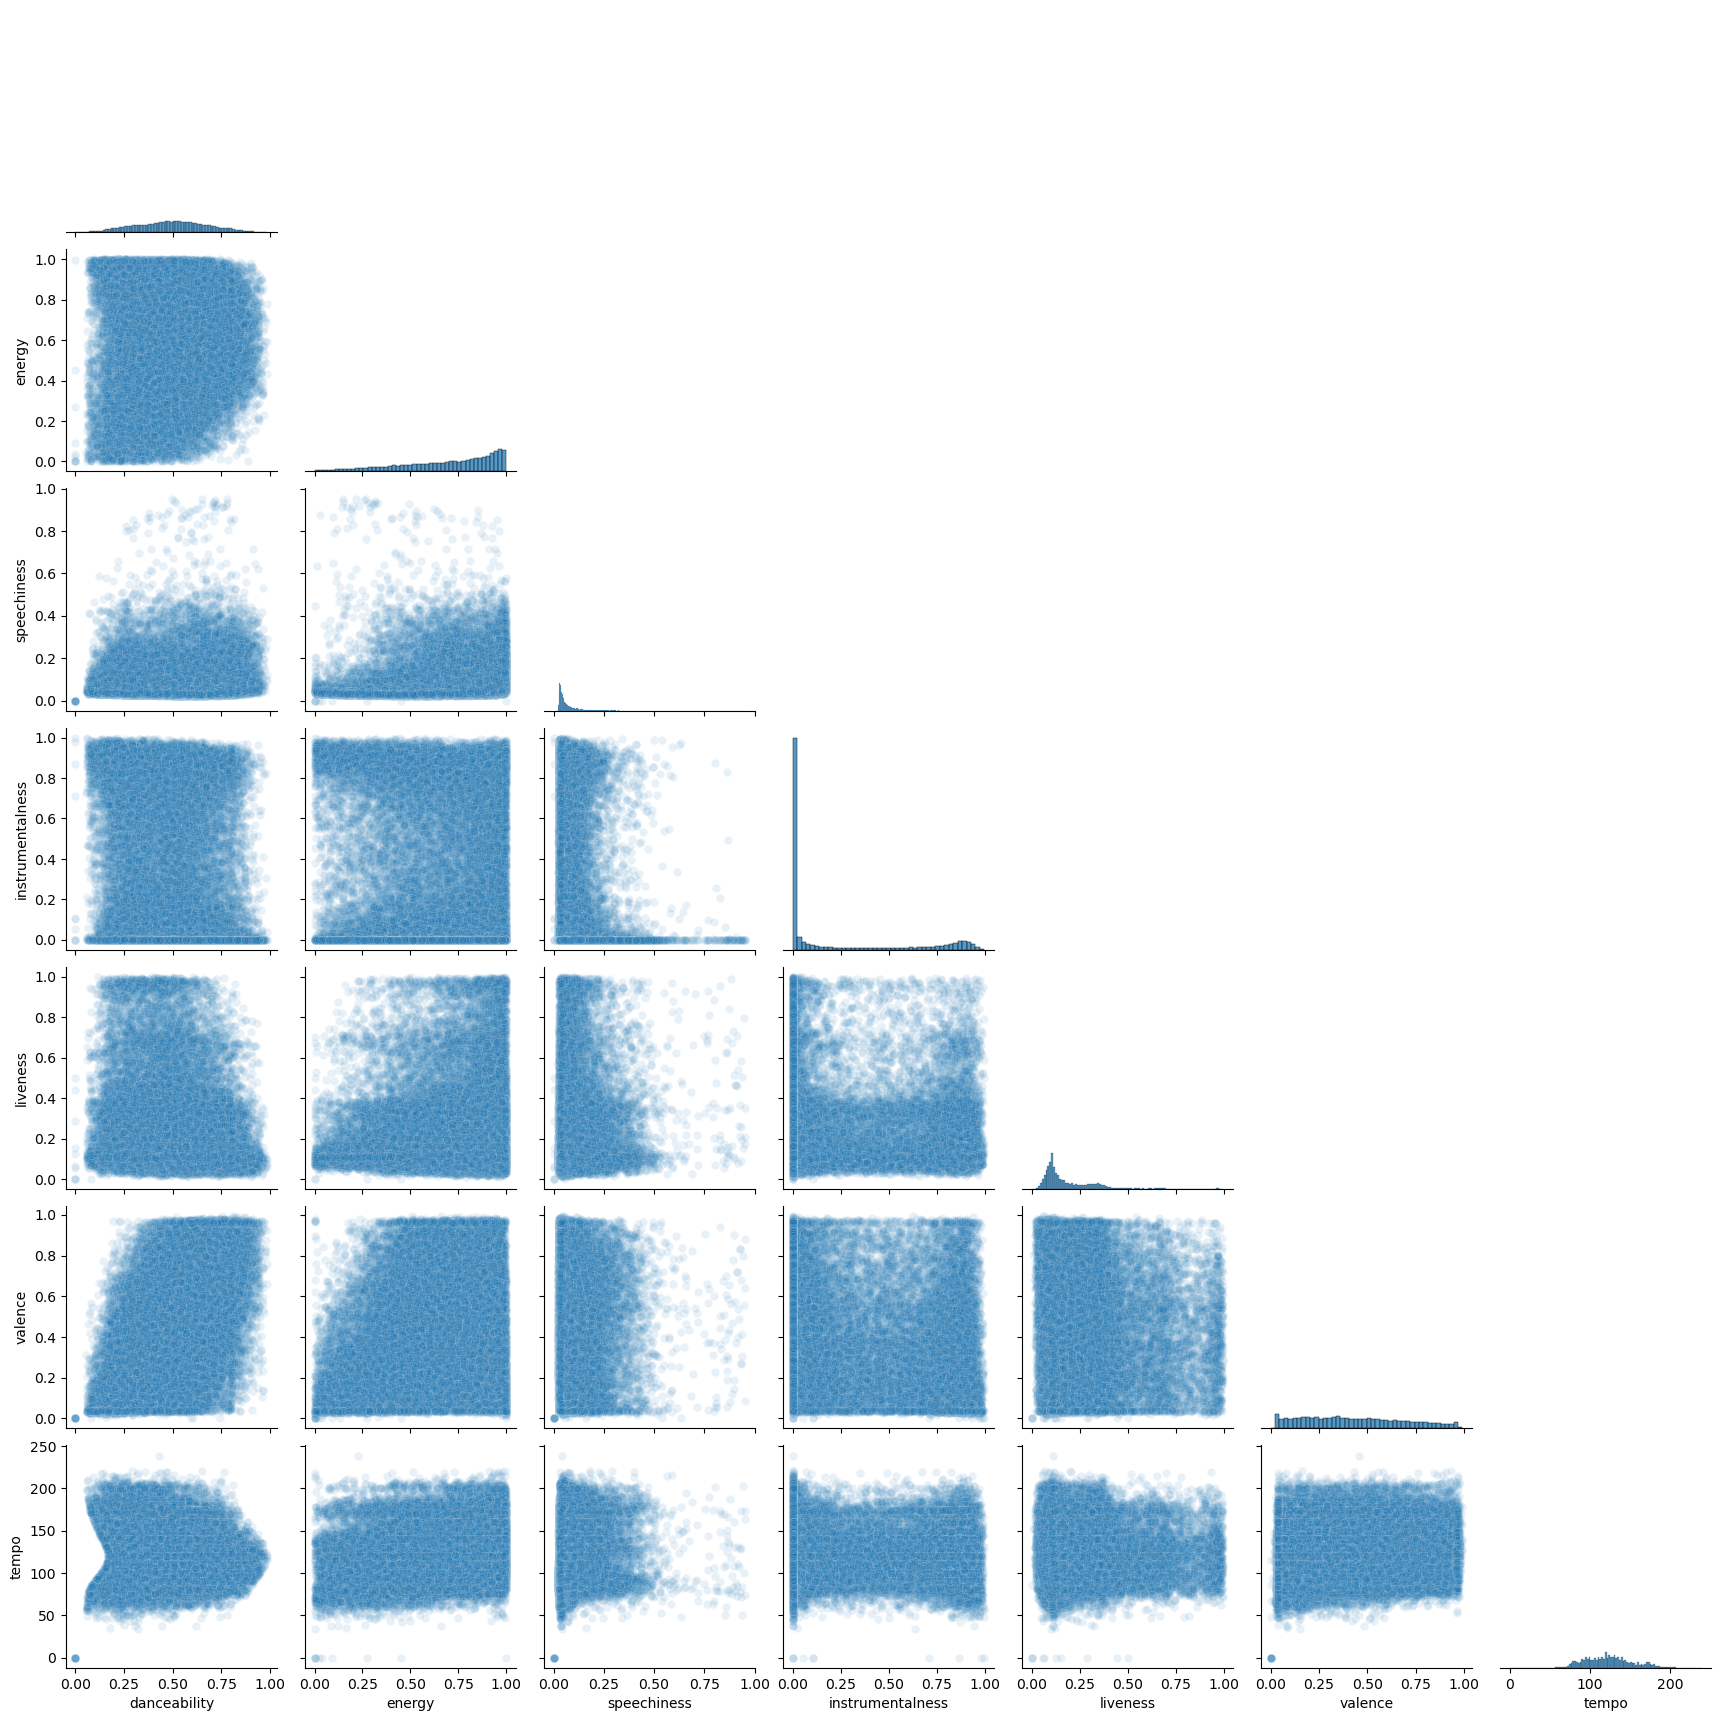

In [6]:
sns.pairplot(X, corner=True, plot_kws={"alpha": 0.1})
plt.show()

---

# Scaling

In [7]:
scaler = MinMaxScaler()
X_s = scaler.fit_transform(X)

---

# Clustering Models <a name="Clustering"></a>

## K-Means Clustering <a name="kmeans"></a>

In [9]:
def gridsearch_kmeans(data, k_range):

    '''
    Train KMeans Clustering on a range of values of k (number of clusters) with comparison on inertia, silhouette and cluster sizes

    Input
    ---------------
    data: data points which we want to find clusters from
    data_s: the scaled dataset
    k_range: the range of values of k (number of clusters)

    Output
    ---------------
    A dictionary storing the clustering results with "num_clusters" and the corresponding "inertia", "silhouette" and "cluster_sizes"

    '''

    # creating an empty dictionary to store the results
    results = {
        "num_clusters": [],
        "inertia": [],
        "silhouette": [],
        "cluster_sizes": []
    }

    for k in k_range:
        print(f"Working on k={k}...", end="\r")

        # fit clustering
        kmeans = KMeans(n_clusters=k, n_init=10)
        kmeans.fit(data)

        # get labels
        labels = kmeans.predict(data)

        # score
        inertia = kmeans.inertia_
        silhouette = silhouette_score(data, labels)

        # save labels info
        results["num_clusters"].append(k)
        results["inertia"].append(inertia)
        results["silhouette"].append(silhouette)
        unique_labels, counts = np.unique(labels, return_counts=True) # returning unique values/labels and their counts
        results["cluster_sizes"].append(counts)

    return results

In [10]:
k_means_results = gridsearch_kmeans(X_s, range(2, 11))

In [11]:
k_means_results = pd.DataFrame(k_means_results).set_index("num_clusters")
k_means_results

inertia  silhouette  \
num_clusters                             
2             11146.370150    0.363333   
3              9115.578169    0.243671   
4              7714.575342    0.256420   
5              6853.817394    0.253953   
6              6201.495570    0.260284   
7              5697.863992    0.262277   
8              5354.535214    0.231008   
9              5082.382529    0.206425   
10             4905.573200    0.200261   

                                                  cluster_sizes  
num_clusters                                                     
2                                                [12744, 36804]  
3                                         [20034, 12100, 17414]  
4                                   [14729, 11620, 13970, 9229]  
5                              [8123, 13719, 14394, 4119, 9193]  
6                        [13432, 2936, 4091, 8635, 7987, 12467]  
7                  [3771, 2903, 8626, 13121, 3909, 12365, 4853]  
8             [4847, 9253, 6809, 2813, 11603, 3865, 3739, 6619]  
9             [5842, 6797, 2715, 3829, 4831, 3726, 8347, 554...  
10            [6712, 8501, 5844, 4218, 2949, 2651, 2715, 788...

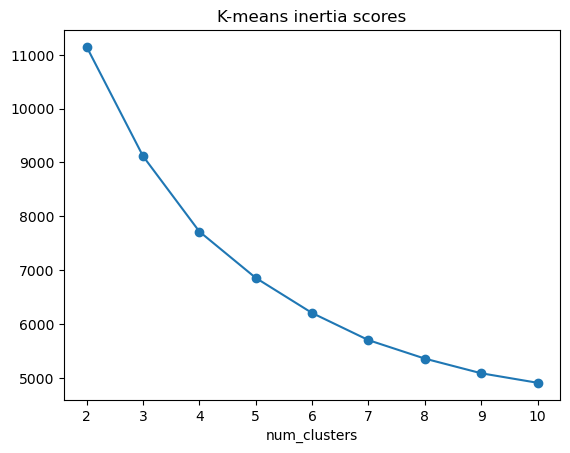

In [12]:
k_means_results["inertia"].plot(marker="o", title="K-means inertia scores")
plt.show()

The inertia decreases gradually with the number of clusters, but there is no obvious "elbow point" in the scree plot. Hence, we look at the silhouette scores then.

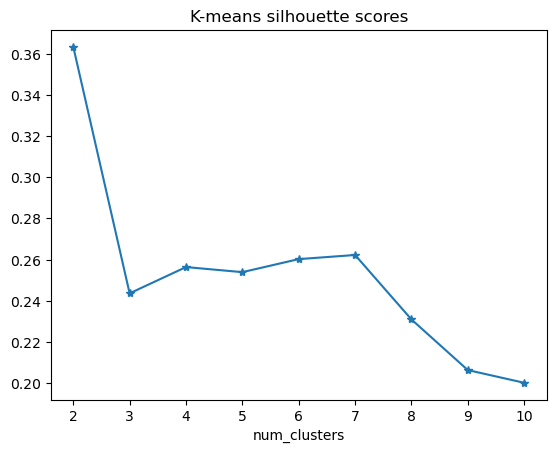

In [13]:
k_means_results["silhouette"].plot(marker="*", title="K-means silhouette scores")
plt.show()

Using K-Means Clustering, k = 2 has the best silhouette score (0.363) among the range k = 2-10.

After k = 2, the models with number of clusters being 3 to 7 have similar silhouette scores, all being around the range of 0.24 to 0.26.

## Agglomerative Hierarchical Clustering <a name="agg"></a>

In [7]:
def gridsearch_agg(data, k_range):

    '''
    Train Agglomerative Hierarchical Clustering Models on a range of values of k (number of clusters) with comparison on silhouette and cluster sizes

    Input
    ---------------
    data: data points which we want to find clusters from
    k_range: the range of values for number of clusters to be searched

    Output
    ---------------
    A dictionary storing the clustering results with "num_clusters" and the corresponding "silhouette" and "cluster_sizes"

    '''

    # creating an empty dictionary to store the results
    results = {
        "num_clusters": [],
        "cluster_sizes": [],
        "silhouette": []
    }

    for k in k_range:
        print(f"Working on k={k}...", end="\r")

        # fit clustering
        agg_model = AgglomerativeClustering(n_clusters=k)

        # get labels
        labels = agg_model.fit_predict(data)

        # save labels info
        results["num_clusters"].append(k)
        results["silhouette"].append(silhouette_score(data, labels))
        unique_labels, counts = np.unique(labels, return_counts=True) # returning unique values/labels and their counts
        results["cluster_sizes"].append(counts)

    return results

In [8]:
agg_results = gridsearch_agg(X_s, range(2,11))

In [9]:
agg_results = pd.DataFrame(agg_results).set_index("num_clusters")
agg_results

cluster_sizes  silhouette
num_clusters                                                               
2                                                [37258, 12290]    0.328643
3                                         [25369, 12290, 11889]    0.178260
4                                  [12290, 11663, 11889, 13706]    0.187620
5                             [11663, 9260, 11889, 13706, 3030]    0.175531
6                        [9260, 13706, 11889, 8660, 3030, 3003]    0.176326
7                  [13706, 3833, 11889, 8660, 3030, 3003, 5427]    0.182073
8             [11889, 3833, 7339, 8660, 3030, 3003, 5427, 6367]    0.147931
9             [7339, 3833, 5427, 8660, 3030, 3003, 8361, 636...    0.132489
10            [3833, 8660, 5427, 6367, 3030, 3003, 8361, 565...    0.135557

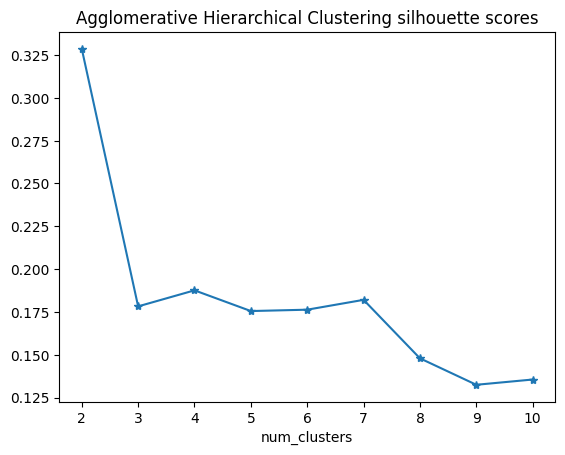

In [10]:
agg_results["silhouette"].plot(marker="*", title="Agglomerative Hierarchical Clustering silhouette scores")
plt.show()

Using Agglomerative Hierarchical Clustering, k = 2 has the best silhouette score (0.329) among the range k = 2-10.

After k = 2, the models with number of clusters being 3 to 7 have similar silhouette scores, all being around the range of 0.17 to 0.19.

In terms of silhouette score, the Agglomerative Hierarchical Clustering performs slightly worse than K-Means Clustering.

## Gaussian Mixture Model <a name="gmm"></a>

In [16]:
def gridsearch_gmm(data, k_range):

    '''
    Train Gaussian Mixture Models on a range of values of k (number of components) with comparison on silhouette and cluster sizes

    Input
    ---------------
    data: data points which we want to find clusters from
    k_range: the range of values of k (number of components)

    Output
    ---------------
    A dictionary storing the clustering results with "num_clusters" and the corresponding "silhouette" and "cluster_sizes"

    '''

    # creating an empty dictionary to store the results
    results = {
        "num_clusters": [],
        "cluster_sizes": [],
        "silhouette": []
    }

    for k in k_range:
        print(f"Working on k={k}...", end="\r")

        # fit clustering
        gmm = GaussianMixture(n_components=k)

        # get labels
        labels = gmm.fit_predict(data)

        # save labels info
        results["num_clusters"].append(k)
        results["silhouette"].append(silhouette_score(data, labels))
        unique_labels, counts = np.unique(labels, return_counts=True) # returning unique values/labels and their counts
        results["cluster_sizes"].append(counts)

    return results

In [17]:
gmm_results = gridsearch_gmm(X_s, range(2, 11))

In [18]:
gmm_results = pd.DataFrame(gmm_results).set_index("num_clusters")
gmm_results

cluster_sizes  silhouette
num_clusters                                                               
2                                                [25050, 24498]    0.152406
3                                         [14672, 10917, 23959]    0.042351
4                                   [11740, 15175, 9954, 12679]    0.016807
5                              [9025, 14596, 9960, 11113, 4854]   -0.006682
6                        [12543, 4732, 11401, 5372, 5864, 9636]    0.008450
7                  [12251, 5805, 2597, 4214, 8209, 11828, 4644]   -0.030543
8             [9017, 6778, 5086, 10564, 4558, 3787, 4806, 4952]   -0.035490
9             [5783, 5139, 9871, 2980, 7779, 8183, 4166, 232...   -0.022931
10            [3046, 5944, 9189, 8280, 1962, 5453, 3545, 276...   -0.035271

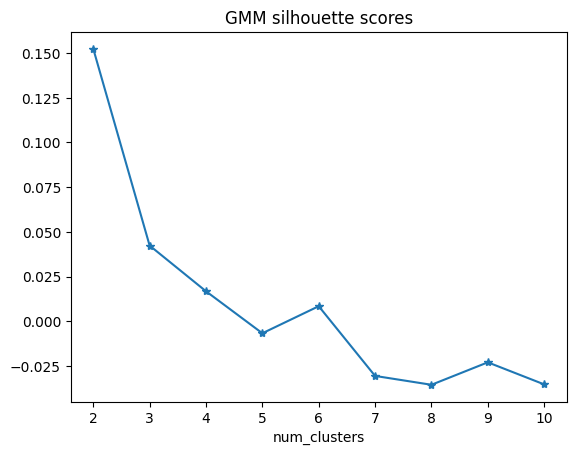

In [19]:
gmm_results["silhouette"].plot(marker="*", title="GMM silhouette scores")
plt.show()

Using Gaussian Mixture Models, k = 2 has the best silhouette score (0.152) among the range of k = 2-10.

GMM performs quite badly after k = 4. If we want the number of clusters to be above 4, we shall not consider using GMM.

## DBSCAN <a name="dbscan"></a>

In [11]:
def gridsearch_dbscan(data, eps_range, min_samples_range):

    '''
    Train DBSCAN on combinations of epsilon and min_samples with comparison on noise points, cluster sizes and silhouette scores

    Input
    ---------------
    data: data points which we want to find clusters from
    eps_range: the range of epsilon values to be searched
    min_samples_range: the range of min_samples to be searched

    Output
    ---------------
    A dictionary storing the clustering results with "eps" and "min_samples" with the corresponding "noise_points", "num_clusters", "cluster_sizes" and "silhouette"

    '''

    # creating an empty dictionary to store the results
    results = {
        "eps": [],
        "min_samples": [],
        "noise_points": [],
        "num_clusters": [],
        "cluster_sizes": [],
        "silhouette": []
    }

    # nested for loop to search through each combination of epsilon and min_sample
    for epsilon in eps_range:
        for min_samples in min_samples_range:
            print(f"Working on eps={epsilon}, min_samples={min_samples}...", end="\r")

            results["eps"].append(epsilon)
            results["min_samples"].append(min_samples)

            # fit clustering
            dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)

            # get labels
            labels = dbscan.fit_predict(data)

            # remove noise
            is_noise = labels == -1
            not_noise = labels != -1
            non_noise_labels = labels[not_noise]
            unique_labels, counts = np.unique(non_noise_labels, return_counts=True)

            results["noise_points"].append(is_noise.sum())
            results["num_clusters"].append(len(counts))
            results["cluster_sizes"].append(counts)

            # silhouette score - only works if we have more than 1 cluster
            if len(counts) <= 1:
                results["silhouette"].append(np.nan)
            else:
                silhouette = silhouette_score(data[not_noise], labels[not_noise])
                results["silhouette"].append(silhouette)

    return results

In [26]:
dbscan_results = gridsearch_dbscan(X_s, [0.1, 0.11, 0.12], [30, 40, 50, 60, 70])

In [27]:
dbscan_results = pd.DataFrame(dbscan_results)
dbscan_results.sort_values("silhouette", ascending=False)

eps  min_samples  noise_points  num_clusters  \
3   0.10           60         37196             2   
2   0.10           50         34661             2   
9   0.11           70         32335             2   
8   0.11           60         30633             2   
7   0.11           50         29008             2   
14  0.12           70         27400             2   
13  0.12           60         26045             2   
12  0.12           50         24813             2   
5   0.11           30         25144             4   
11  0.12           40         23373             5   
10  0.12           30         21239             7   
0   0.10           30         29523             3   
6   0.11           40         27197             3   
1   0.10           40         32071             3   
4   0.10           70         39702             4   

                          cluster_sizes  silhouette  
3                          [12140, 212]    0.660531  
2                          [14616, 271]    0.634818  
9                          [16912, 301]    0.622166  
8                          [18587, 328]    0.609772  
7                          [20111, 429]    0.599547  
14                         [21709, 439]    0.592616  
13                         [22877, 626]    0.583298  
12                         [23956, 779]    0.574813  
5                  [23451, 878, 32, 43]    0.461540  
11             [25007, 998, 40, 40, 90]    0.435641  
10  [26166, 1383, 323, 67, 63, 287, 20]    0.404862  
0                      [19499, 506, 20]    0.164869  
6                      [21704, 614, 33]    0.153403  
1                      [17092, 344, 41]    0.142895  
4                   [9549, 177, 60, 60]    0.106251

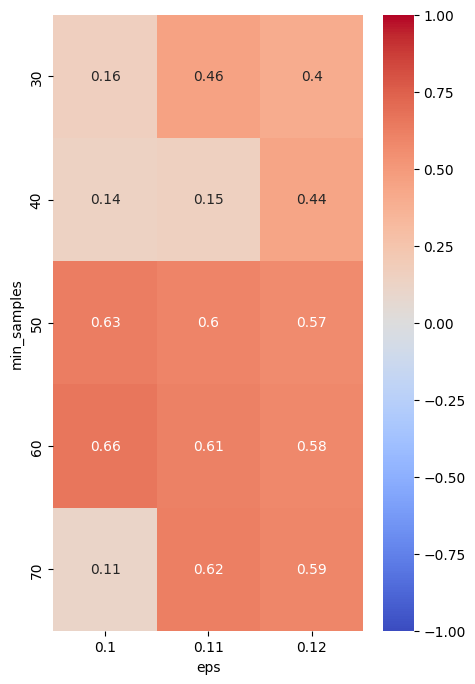

In [28]:
# silhouette scores round to two digits for visualization
dbscan_results["silhouette"] = dbscan_results["silhouette"].round(2)

# heatmap showing silhouette scores
plt.figure(figsize=(5,8))
sns.heatmap(
    pd.pivot(dbscan_results, index="min_samples", columns="eps", values="silhouette"),
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    annot=True
)
plt.show()

Here, we have run three rounds of coarse-to-fine grid searching on the epsilon vlaues and min_samples values of DBSCAN. The first round was on eps = [0.01, 0.1, 0.5] and min_samples = [10, 50, 100]; the second round was on eps = [0.08, 0.09, 0.1, 0.11, 0.12] and min_samples = [30, 50, 70]; the third round was on eps = [0.1, 0.11, 0.12] and min_samples = [30, 40, 50, 60, 70]. (See Appendix for the first two rounds)

We can see clearly from the heatmap that, in terms of silhouette score, DBSCAN with eps = 0.1 and min_samples = 60 has the best performance (silhouette score = 0.66).

However, looking at the dbscan_results dataframe, the number of noise points is 37,196 while the cluster sizes are 12,140 and 212. A large majority of data points could not be classified into any cluster and are regarded as noise points. Therefore, we cannot use this clustering.

The failure is expected as DBSCAN clustering is a density-based clustering model. Viewing the pairplot of the datapoints on the audio features, we can easily find that the data points are close to each other and, if there are any clusters, the clusters would probably overlap each other to a great extent. In such case, DBSCAN is expected to fail to identify many of the data points into clusters.

## Comparing the models <a name="compare"></a>

Comparing all 4 clustering models, K-Means Clustering has the best performance in terms of silhouette score. I will use K-Means Clustering for grouping and labelling below.

For the number of clusters, despite k = 2 having the best silhouette score, using only 2 clusters might not be a good way of grouping music tracks as there ought to be more diversity of music cohorts in the databse. The next option k = 7 with the second highest silhouette score would be a good one, as it gives some more variety in the grouping of music.

---

# K-Means Clustering with k=7 <a name="kmeans7"></a>

In [8]:
def train_kmeans(data, data_s, k):

    '''
    Train K-Means Clustering on a dataset, get the inertia, silhouette score and cluster sizes,
    return the model and the labelled dataset

    Input
    ---------------
    data: the original dataset which we want to find clusters from
    data_s: the scaled dataset
    k: the number of clusters we want

    Output
    ---------------
    Printing:
    Number of clusters, inertia, silhouette, cluster sizes

    Returning:
    the trained K-Means model, the labelled dataset

    '''

    # fit clustering
    kmeans = KMeans(n_clusters=k, n_init=10)
    kmeans.fit(data_s)

    # get labels and cluster centers
    labels = kmeans.predict(data_s)

    # score
    inertia = kmeans.inertia_
    silhouette = silhouette_score(data_s, labels)

    # cluster sizes
    unique_labels, counts = np.unique(labels, return_counts=True)

    # printing results
    print(f"K-Means Clustering with number of clusters = {k}")
    print("========================")
    print(f"Inertia: {inertia:.4f}")
    print(f"Silhouette: {silhouette:.4f}")
    print(f"Cluster sizes: {list(counts)}")

    # labelling the data
    df = data.copy()
    df["cluster"] = labels

    # return the model and the labelled data
    return kmeans, df

In [9]:
kmeans, df_kmeans = train_kmeans(X, X_s, 7)

K-Means Clustering with number of clusters = 7
Inertia: 5697.8641
Silhouette: 0.2623
Cluster sizes: [2902, 12364, 13120, 4879, 3770, 8627, 3886]


In [23]:
## saving the model to 'kmeans.pkl'
# joblib.dump(kmeans, 'kmeans.pkl')

['kmeans.pkl']

In [1]:
# # uncomment this cell and load the model from 'kmeans.pkl' here
# joblib.load('kmeans.pkl')

In [11]:
df_kmeans.head()

danceability  energy  speechiness  instrumentalness  liveness  valence  \
0         0.355   0.918       0.0746          0.000000    0.0971    0.240   
1         0.409   0.892       0.0336          0.000000    0.2070    0.651   
2         0.508   0.826       0.0400          0.000459    0.0878    0.543   
3         0.279   0.664       0.0371          0.000655    0.1330    0.490   
4         0.515   0.430       0.0369          0.000141    0.1290    0.104   

     tempo  cluster  
0  148.114        1  
1  174.426        2  
2  120.012        2  
3  104.560        1  
4   91.841        5

In [25]:
# # saving the labelled dataset to df_kmeans.csv
# df_kmeans.to_csv(file_path + 'data/df_kmeans.csv', index=False)

In [57]:
# check_file_kmeans = os.path.isfile(file_path + 'data/df_kmeans.csv')

# print(check_file_kmeans)

True


In [58]:
# # uncomment this cell and load df_kmeans for pairplot here
# df_kmeans = pd.read_csv(file_path + 'data/df_kmeans.csv')
# df_kmeans.head()

danceability  energy  speechiness  instrumentalness  liveness  valence  \
0         0.355   0.918       0.0746          0.000000    0.0971    0.240   
1         0.409   0.892       0.0336          0.000000    0.2070    0.651   
2         0.508   0.826       0.0400          0.000459    0.0878    0.543   
3         0.279   0.664       0.0371          0.000655    0.1330    0.490   
4         0.515   0.430       0.0369          0.000141    0.1290    0.104   

     tempo  cluster  
0  148.114        1  
1  174.426        2  
2  120.012        2  
3  104.560        1  
4   91.841        5

## Pairplots

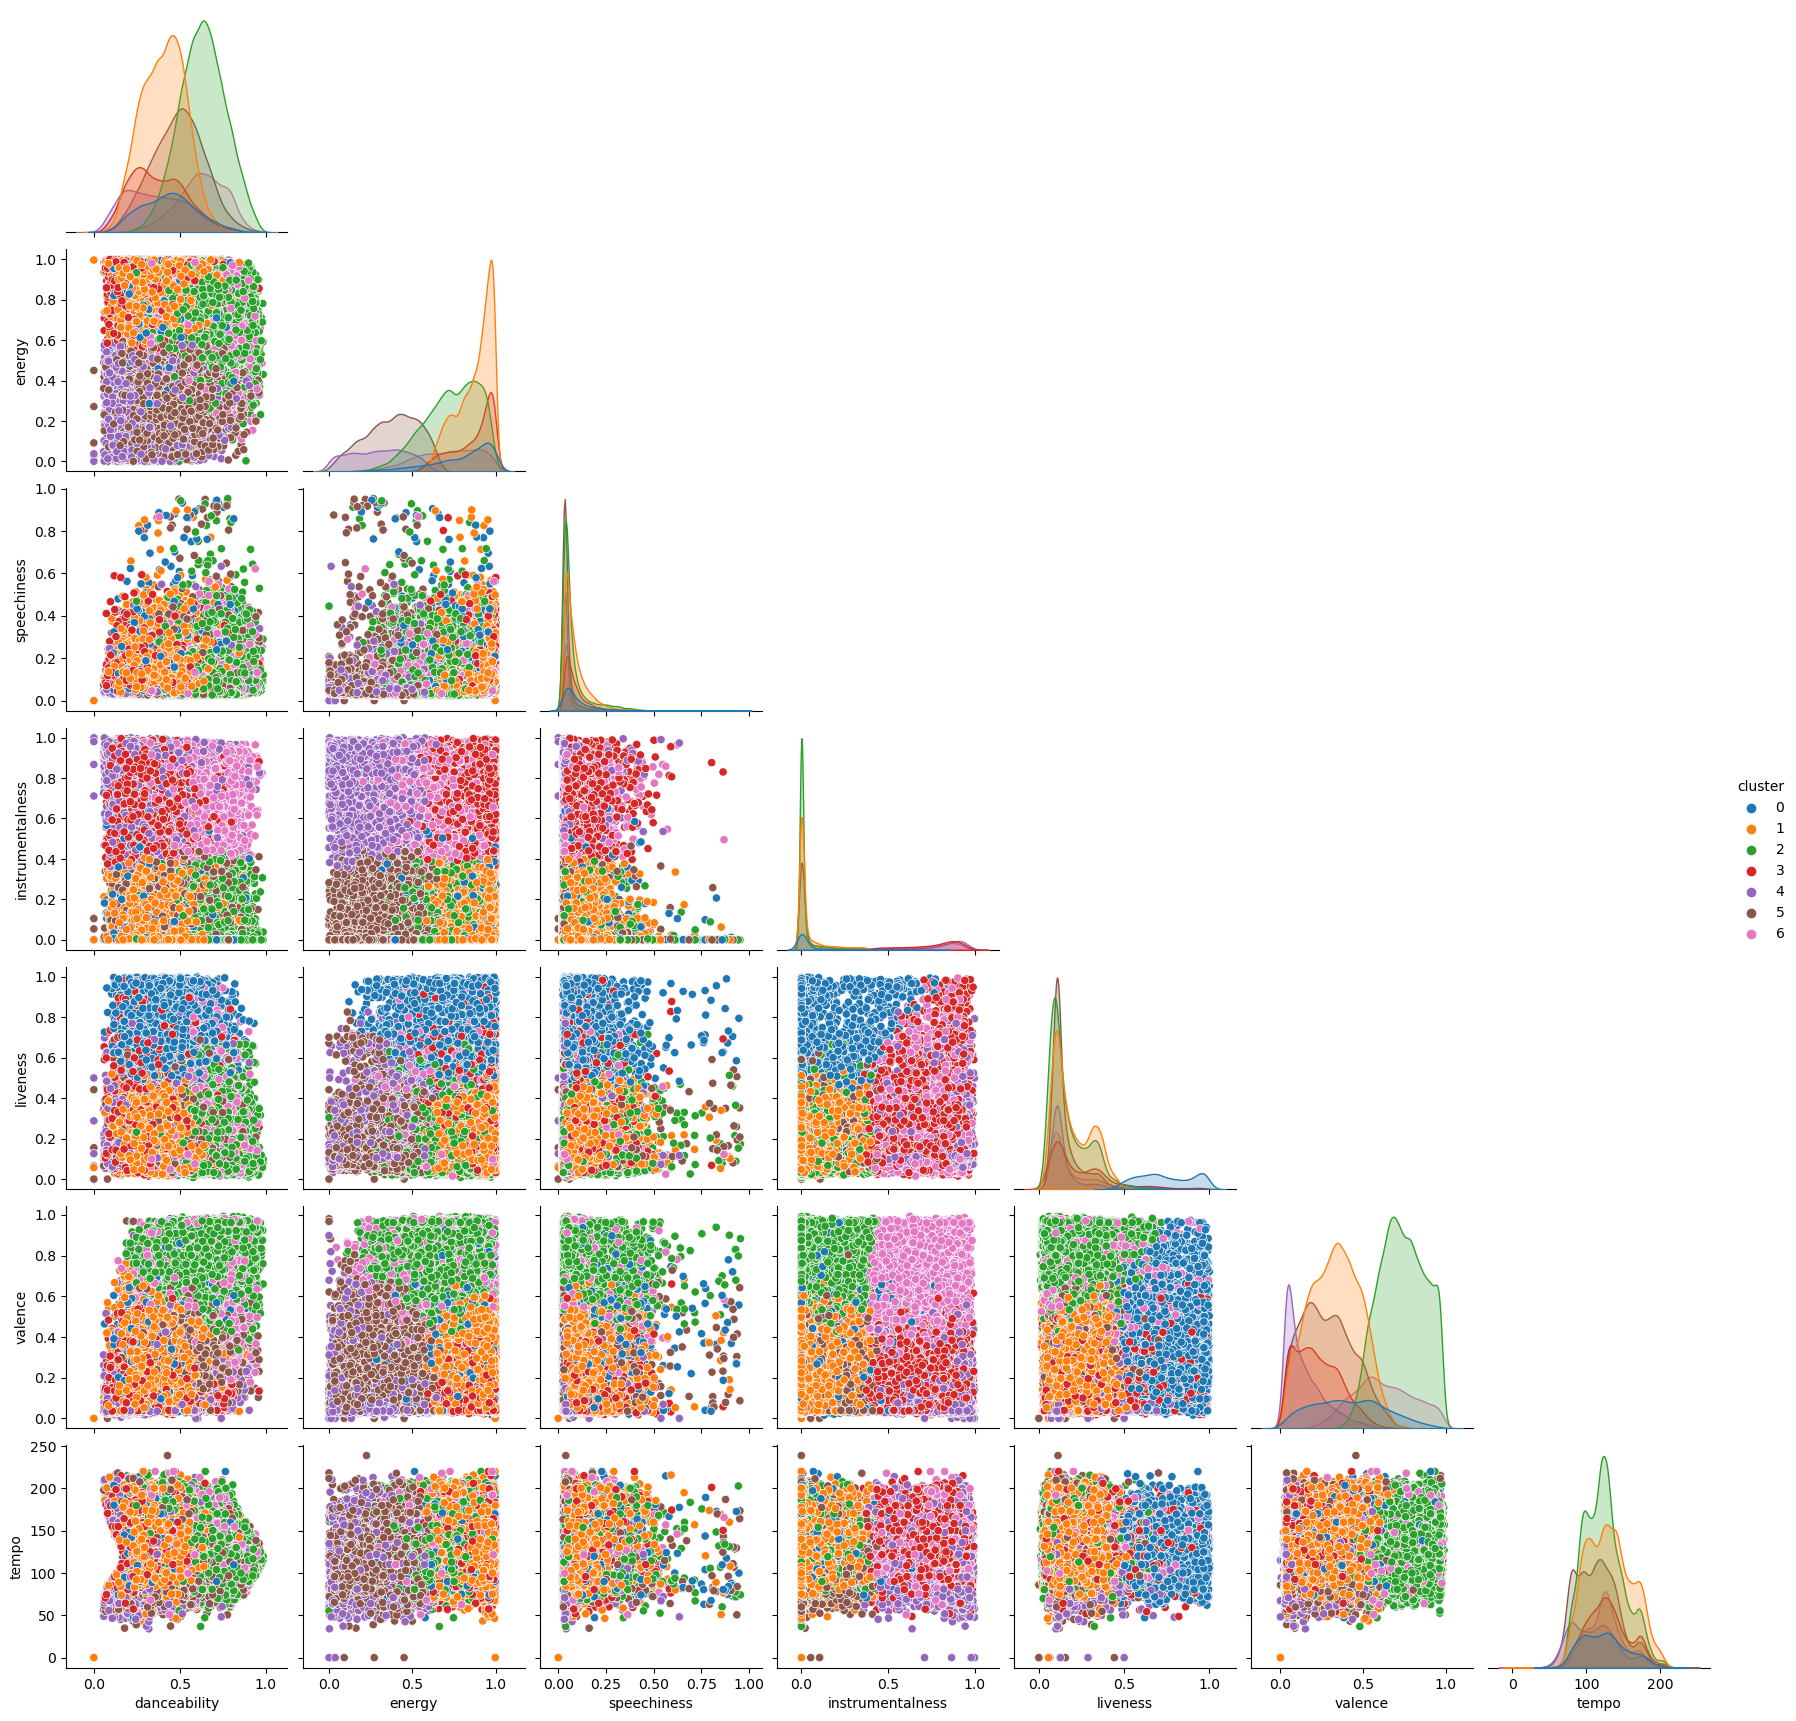

In [59]:
# plotting the clusters
sns.pairplot(data=df_kmeans, hue="cluster", palette="tab10", corner=True)
plt.show()

## df_track_label

We now put the labels to the tracks in the database, which will be used later for evaluation on recommendation.

In [60]:
df_track_cleaned = pd.read_csv(file_path + 'data/df_track_cleaned.csv')

df_track_label = df_track_cleaned[['track_id']].copy()
df_track_label['cluster'] = df_kmeans['cluster']
df_track_label.head()

track_id  cluster
0  TRIOREW128F424EAF0        1
1  TRRIVDJ128F429B0E8        2
2  TROUVHL128F426C441        2
3  TRUEIND128F93038C4        1
4  TRLNZBD128F935E4D8        5

In [62]:
# df_track_label.to_csv(file_path + 'data/df_track_label.csv', index=False)

In [63]:
# check_file_track_label = os.path.isfile(file_path + 'data/df_track_label.csv')

# print(check_file_track_label)

True


In [64]:
# # uncomment this cell and run df_track_label from here
# df_track_label = pd.read_csv(file_path + 'data/df_track_label.csv')
# df_track_label.head()

track_id  cluster
0  TRIOREW128F424EAF0        1
1  TRRIVDJ128F429B0E8        2
2  TROUVHL128F426C441        2
3  TRUEIND128F93038C4        1
4  TRLNZBD128F935E4D8        5

---

# Correspondences of the clusters to audio features <a name="correspondences"></a>

In [65]:
# cluster centers
cluster_centers = kmeans.cluster_centers_
col_names = ['danceability', 'energy', 'speechiness', 'instrumentalness', 'liveness', 'valence', 'tempo_scaled']
df_cluster_centers = pd.DataFrame(data=cluster_centers, columns=col_names)
df_cluster_centers['cluster'] = range(kmeans.n_clusters)

df_cluster_centers

danceability    energy  speechiness  instrumentalness  liveness   valence  \
0      0.442640  0.794694     0.113462          0.063361  0.743395  0.418711   
1      0.411774  0.871815     0.094496          0.043531  0.196374  0.330786   
2      0.640097  0.731718     0.083605          0.024564  0.173341  0.739527   
3      0.377444  0.862727     0.092300          0.755797  0.242954  0.226488   
4      0.370211  0.295772     0.048459          0.813163  0.158639  0.147672   
5      0.497059  0.376320     0.051814          0.041970  0.153172  0.289686   
6      0.635490  0.705688     0.067775          0.748359  0.185252  0.628714   

   tempo_scaled  cluster  
0      0.519203        0  
1      0.547873        1  
2      0.516740        2  
3      0.538060        3  
4      0.463735        4  
5      0.479154        5  
6      0.525427        6

## Barplots

In [66]:
# Reshape the DataFrame for Seaborn
df_melted = pd.melt(df_cluster_centers, id_vars=['cluster'], var_name='feature', value_name='value')
df_melted

cluster           feature     value
0         0      danceability  0.442640
1         1      danceability  0.411774
2         2      danceability  0.640097
3         3      danceability  0.377444
4         4      danceability  0.370211
5         5      danceability  0.497059
6         6      danceability  0.635490
7         0            energy  0.794694
8         1            energy  0.871815
9         2            energy  0.731718
10        3            energy  0.862727
11        4            energy  0.295772
12        5            energy  0.376320
13        6            energy  0.705688
14        0       speechiness  0.113462
15        1       speechiness  0.094496
16        2       speechiness  0.083605
17        3       speechiness  0.092300
18        4       speechiness  0.048459
19        5       speechiness  0.051814
20        6       speechiness  0.067775
21        0  instrumentalness  0.063361
22        1  instrumentalness  0.043531
23        2  instrumentalness  0.024564
24        3  instrumentalness  0.755797
25        4  instrumentalness  0.813163
26        5  instrumentalness  0.041970
27        6  instrumentalness  0.748359
28        0          liveness  0.743395
29        1          liveness  0.196374
30        2          liveness  0.173341
31        3          liveness  0.242954
32        4          liveness  0.158639
33        5          liveness  0.153172
34        6          liveness  0.185252
35        0           valence  0.418711
36        1           valence  0.330786
37        2           valence  0.739527
38        3           valence  0.226488
39        4           valence  0.147672
40        5           valence  0.289686
41        6           valence  0.628714
42        0      tempo_scaled  0.519203
43        1      tempo_scaled  0.547873
44        2      tempo_scaled  0.516740
45        3      tempo_scaled  0.538060
46        4      tempo_scaled  0.463735
47        5      tempo_scaled  0.479154
48        6      tempo_scaled  0.525427

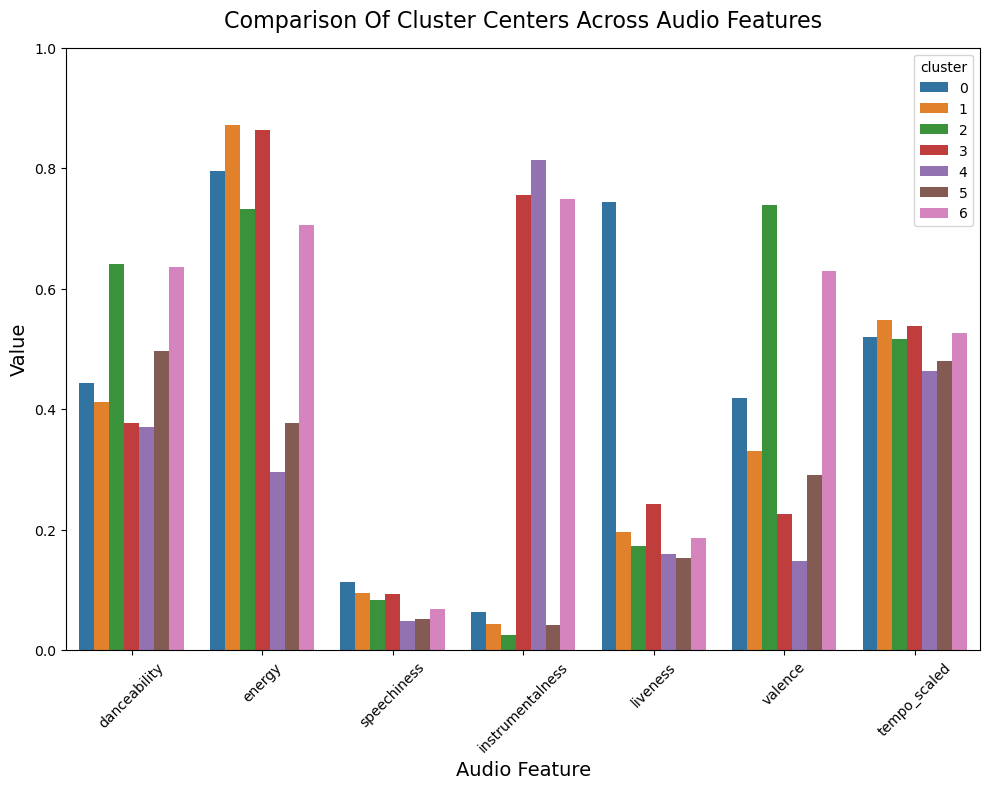

In [67]:
# Create a grouped bar plot using Seaborn
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.barplot(x='feature', y='value', hue='cluster', data=df_melted)
plt.xlabel('Audio Feature', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Comparison Of Cluster Centers Across Audio Features', fontsize=16, y=1.02)
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Radarplots

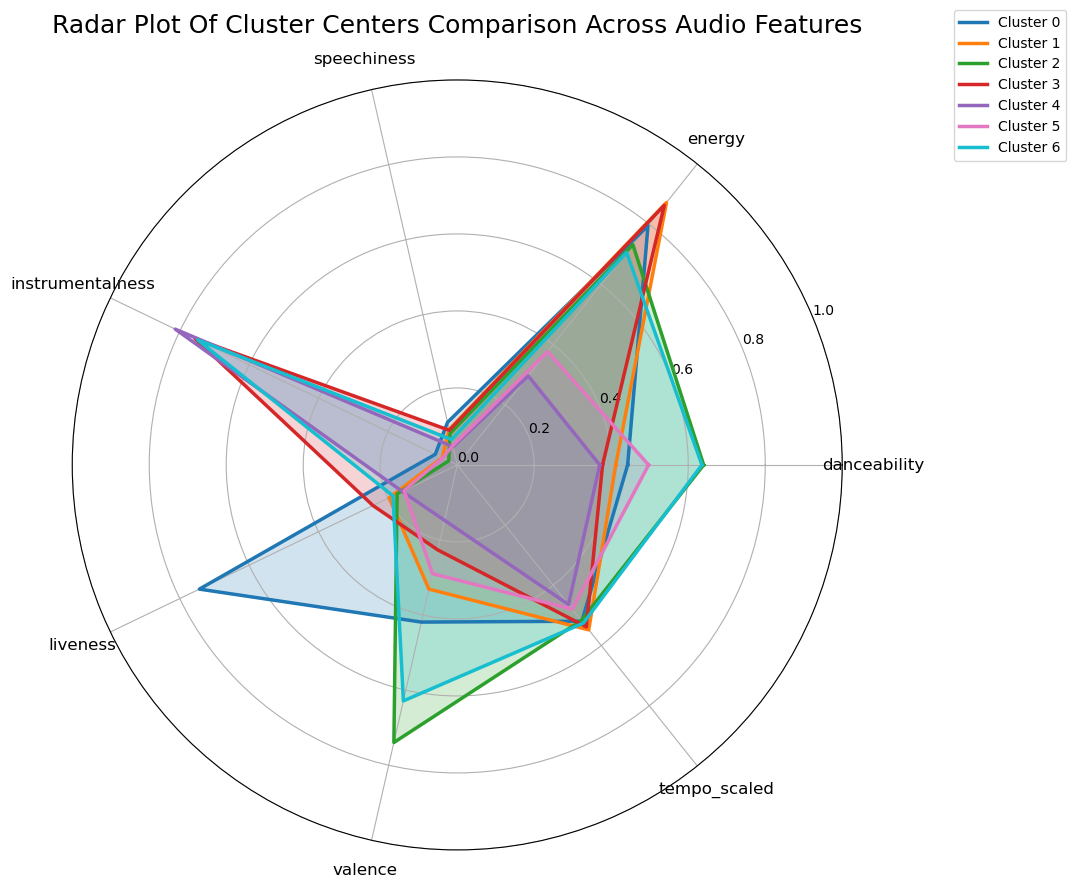

In [68]:
# Features
features = list(df_cluster_centers.columns[:7])

# Number of features
num_features = len(features)

# Create a radar plot
angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()
angles += angles[:1]

# Initialize the radar plot
plt.rcParams["figure.figsize"] = (20,10)
plt.figure()
ax = plt.subplot(111, polar=True)
plt.xticks(angles[:-1], features, fontsize=12, y=-0.03)
ax.set_yticks([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylim(0, 1)

# Plot data for clustesrs
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:pink', 'tab:cyan']
for i in range(7):
    values_cluster = df_cluster_centers.iloc[i,:7].values.flatten().tolist()
    values_cluster += values_cluster[:1]
    ax.plot(angles, values_cluster, linewidth=2.5, linestyle='solid', color=colors[i], label=f"Cluster {i}")
    ax.fill(angles, values_cluster, colors[i], alpha=0.2)

# Setting a legend and a title
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Radar Plot Of Cluster Centers Comparison Across Audio Features', fontsize=18, y=1.05)
plt.show()

From the barplots and radarplots above, we can see there are several obvious differentiating characteristics of cluster centers for the clusters:

- Only cluster 0 has a cluster center with high `liveness` value (0.74)
- Only clusters 2 and 6 have cluster centers with relatively higher `valence` values (0.74; 0.63)
- Clusters 2 and 6 have cluster centers with relatively higher `danceability` values, and cluster 5 has a cluster center with moderate `danceability` value (0.50)
- Clusters 3, 4 and 6 have cluster centers with relatively higher `instrumentalness` values (0.76; 0.81; 0.75)
- Only clusters 4 and 5 have cluster centers with relatively lower `energy` values (0.30; 0.38)

The cluster centers of all the clusters have similar values in `tempo_scaled` and `speechiness`.

## Heatmap

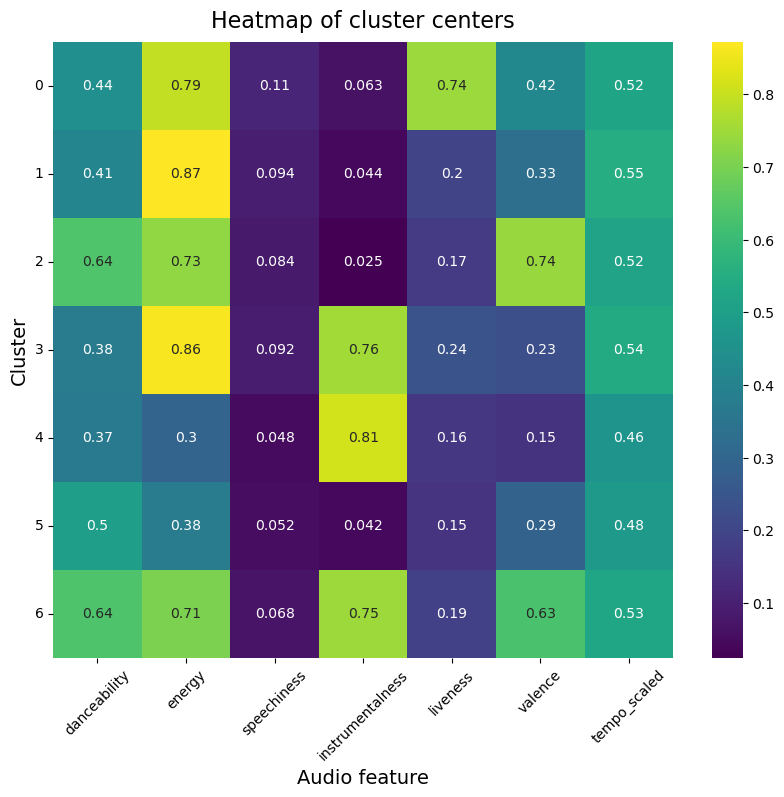

In [69]:
plt.figure(figsize=(10,8))
sns.heatmap(
        data=df_cluster_centers.iloc[:,:7],
        annot=True,
        cmap='viridis'
)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.xlabel('Audio feature', fontsize=14)
plt.ylabel('Cluster', fontsize=14)
plt.title('Heatmap of cluster centers', fontsize=16, y=1.01)
plt.show()

From the heatmap shown, we can summarize the following main characteristics that different one cluster from the other (in terms of cluster center):

**Cluster 0 - the only high `liveness` group**

It has low `danceability`, low `valence` and high `energy`.

&nbsp;

**Cluster 2, 6 - the high `valence`, high `danceability` group**

Cluster 2: high `valence`, high `danceability`, with **low `instrumentalness`**

Cluster 6: high `valence`, high `danceability`, with **high `instrumentalness`**

&nbsp;

**Cluster 4, 5 - the low `energy` group**

Cluster 4: low `energy`, low `valence`, with **high `instrumentalness`**

Cluster 5: low `energy`, low `valence`, with **low `instrumentalness`**

&nbsp;

**Cluster 1, 3 - the low `danceability`, low `valence`, high `energy` group**

Cluster 1: low `danceability`, low `valence`, high `energy`, with **low `instrumentalness`**

Cluster 3: low `danceability`, low `valence`, high `energy`, with **high `instrumentalness`**

They share similar `danceability`, `valence` and `energy` values with Cluster 0.

---

# Notebook Summary

From the above model, I find 7 clusters from the music in the database, which would be useful to act as music cohorts, see if a user's listening history is concentrated in certain music cohort, and evaluate how well the new recommendation could help the user find new tracks different from the cohort in his listening history.

The main characteristics of each cluster are also summarized with the aid of barplot and radarplot above.

I also put the labels for every track aligning with `track_id` in the dataframe *df_track_label*. It will be used in Notebook 05 for evaluation.

---

# Appendix

## Coarse-to-fine Grid Search for DBSCAN <a name="GridSearch_DBSCAN"></a>

As we don't have a clear hint on which range of values for epsilon and min_samples would be better, we start with the coarse-to-fine grid search approach. The process is shown below.

&nbsp;

**1st Search:**

In [20]:
dbscan_results = gridsearch_dbscan(X_s, [0.01, 0.1, 0.5], [10, 50, 100])

In [21]:
dbscan_results = pd.DataFrame(dbscan_results)
dbscan_results.sort_values("silhouette", ascending=False)

eps  min_samples  noise_points  num_clusters  \
4  0.10           50         34661             2   
5  0.10          100         45019             2   
3  0.10           10         21431            39   
0  0.01           10         49548             0   
1  0.01           50         49548             0   
2  0.01          100         49548             0   
6  0.50           10             2             1   
7  0.50           50             6             1   
8  0.50          100             9             1   

                                       cluster_sizes  silhouette  
4                                       [14616, 271]    0.634818  
5                                         [4437, 92]    0.188709  
3  [25181, 2441, 5, 22, 10, 69, 18, 13, 23, 15, 1...   -0.372288  
0                                                 []         NaN  
1                                                 []         NaN  
2                                                 []         NaN  
6                                            [49546]         NaN  
7                                            [49542]         NaN  
8                                            [49539]         NaN

We have some findings at epsilon = 0.10 and min_sample = 50 works best among the three values. So, we go on with a finer search around epsilon = 0.10 and min_sample = 50.

&nbsp;

**2nd Search:**

In [22]:
dbscan_results = gridsearch_dbscan(X_s, [0.08, 0.09, 0.1, 0.11, 0.12], [30, 50, 70])

In [23]:
dbscan_results = pd.DataFrame(dbscan_results)
dbscan_results.sort_values("silhouette", ascending=False)

eps  min_samples  noise_points  num_clusters  \
7   0.10           50         34661             2   
11  0.11           70         32335             2   
10  0.11           50         29008             2   
14  0.12           70         27400             2   
13  0.12           50         24813             2   
9   0.11           30         25144             4   
12  0.12           30         21239             7   
5   0.09           70         46613             2   
6   0.10           30         29523             3   
1   0.08           50         48412             6   
8   0.10           70         39702             4   
3   0.09           30         35440             4   
4   0.09           50         42475             6   
0   0.08           30         43213            12   
2   0.08           70         49548             0   

                                        cluster_sizes  silhouette  
7                                        [14616, 271]    0.634818  
11                                       [16912, 301]    0.622166  
10                                       [20111, 429]    0.599547  
14                                       [21709, 439]    0.592616  
13                                       [23956, 779]    0.574813  
9                                [23451, 878, 32, 43]    0.461540  
12                [26166, 1383, 323, 67, 63, 287, 20]    0.404862  
5                                          [2883, 52]    0.174814  
6                                    [19499, 506, 20]    0.164869  
1                         [526, 194, 63, 211, 66, 76]    0.148034  
8                                 [9549, 177, 60, 60]    0.106251  
3                                [13799, 268, 30, 11]   -0.144056  
4                         [6747, 46, 136, 50, 43, 51]   -0.145381  
0   [5730, 56, 76, 45, 143, 31, 29, 64, 65, 38, 26...   -0.231822  
2                                                  []         NaN

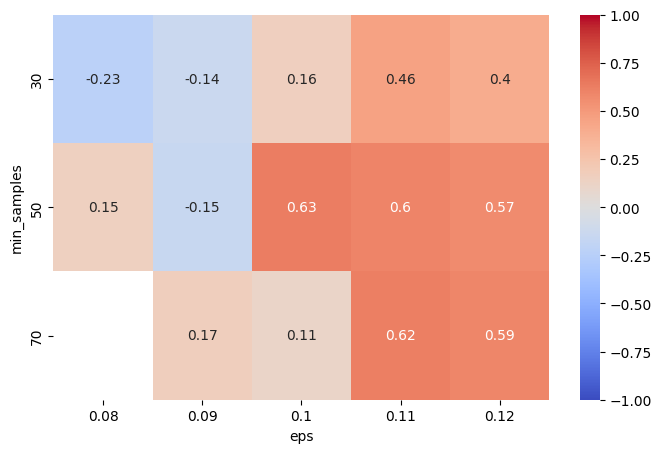

In [25]:
# silhouette scores round to two digits for visualization
dbscan_results["silhouette"] = dbscan_results["silhouette"].round(2)

# heatmap showing silhouette scores
plt.figure(figsize=(8,5))
sns.heatmap(
    pd.pivot(dbscan_results, index="min_samples", columns="eps", values="silhouette"),
    vmin=-1,
    vmax=1,
    cmap="coolwarm",
    annot=True
)
plt.show()

From the heatmap, judging by the silhouette score, DBSCAN clustering works better around epsilon = 0.1, 0.11 and 0.12 and min_samples = 50 and 70. Therefore, we go for the 3rd search (shown in the DBSCAN section above) around epsilon values of 0.1, 0.11, and 0.12 and min_samples values of 30, 40, 50, 60 and 70.